# How to Ride the Shopping Cart

## Abstract

Let’s face it: grocery shopping is not a skill most of us intentionally invested effort in pursuing. However, people more than often find themselves in situations where they return home with two bags of groceries and realize that they are missing the only item they initially were out for. Sometimes, not having a clear idea about our inventory state, we end up being tempted into the all sorts of treats that are over and above our necessities. Or we buy products to showcase our cooking abilities for the family dinner but somehow, we end up with the fridge full of everything, hoping to roll up our sleeves tomorrow. We are often surprised by the number of items we throw away because the expiration date passed two months ago! However, that could change...

## Main Research Question

In this notebook we try to address the following research question:

- Interplay between income and expenses?

### Sub-Questions

In particular, we are interested in the following sub-questions:

- How do households choose to organize their limited annual income according to their shopping expenses?

- Can we infer different household types based on the relation between their income and transaction statistics?

- Are some demographic properties of the household's indicators of this relation as well? That is, can we infer common family values indirectly from this data? 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
# from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

sns.set(style='whitegrid')

np.set_printoptions(suppress=True)

In [2]:
DATA_DIR = 'data/'

CAMPAIGN_DESC = 'campaign_desc.csv'
CAMPAIGN_TABLE = 'campaign_table.csv'
CAUSAL_DATA = 'causal_data.csv'
COUPON = 'coupon.csv'
COUPON_REDEMPT = 'coupon_redempt.csv'
HH_DEMOGRAPHIC = 'hh_demographic.csv'
PRODUCT = 'product.csv'
TRANSACTION_DATA = 'transaction_data.csv'

## Part 1: Introduction

There are several factors that contribute to how people spend their annual income:

1. Income category
    - In our dataset we have several categories ranging from below **15,000** to over **250,000 USD p.a.**
2. Shopping behavior
    - It mainly depends on the day of the week
2. Campaigns play a major role
    - Some households take active participation in campaigns which significantly lowers the expenses
3. Products vary in price
    - Some products are much more expensive than others, nonetheless their purchase is unavoidable
4. Households preferences
    - Households with lower income tend to buy low-budget goods, as opposed to households with higher income that buy high-end goods (like organic food)
5. Demographics

To begin answering our question, we first perform data exploration on the **Dunnhumby** dataset to get initial insight for the task.

## Part 2: Preprocessing

### Loading the Data

For this research question, we only require the `hh_demographic` and `transaction_data` datasets.

In [3]:
df_hh_demographic = pd.read_csv(DATA_DIR + HH_DEMOGRAPHIC, index_col='household_key')

print('Number of households:', len(df_hh_demographic))

df_hh_demographic.head()

Number of households: 801


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown


In [4]:
df_transaction_data = pd.read_csv(DATA_DIR + TRANSACTION_DATA)

print('Number of transactions:', len(df_transaction_data))

df_transaction_data.head()

Number of transactions: 2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


We observe that the `transaction_data` dataset contains a large number (circa 2.5 mil) of transactions. On the other hand, `hh_demographic` dataset is much smaller in size (801).

Furthermore, there are transactions for which demographic data is not present. The reason behind the missing demographic information are privacy issues (as stated in the documentation).

### Handling Missing and Inconsistent Data

In [5]:
print('Columns with missing values in household dataset:',
      np.any(df_hh_demographic.isna().sum()))

print('Columns with missing values in transactions dataset:',
      np.any(df_transaction_data.isna().sum()))

Columns with missing values in household dataset: False
Columns with missing values in transactions dataset: False


There are none missing values in both datasets.  

However, in the `transaction_data` dataset we observed that some entries contain 0 for `SALES_VALUE` (the total amount received by the retailer) and for `QUANTITY` (the number of products purchased). There may be a valid reason why the data had been recorded this way, however we chose to avoid any assumptions and discard these transactions, as it is only a small percentage of the whole dataset. 

In [6]:
c = (df_transaction_data['SALES_VALUE'] != 0) & \
    (df_transaction_data['QUANTITY'] != 0)

df_transaction_data_cleaned = df_transaction_data[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 2576815


Furthermore, following the previous discussion about missing demographic information, we filter the data:

In [7]:
c = df_transaction_data_cleaned['household_key'].isin(df_hh_demographic.index)

df_transaction_data_cleaned = df_transaction_data_cleaned[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 1416672


The `transaction_data` now is half its size before.

**Note**: Although, technically there are none missing values in both datasets, still, the columns: `MARITAL_STATUS_CODE`, `HOMEOWNER_DESC`, and `KID_CATEGORY_DESC` in the `hh_demographic` dataset, take values `U`, `Unknown`, and `None/Unknown` respectively which are unknown values. However, since the columns are categorical, we treat this values as yet another category with hope that later on we can obtain some useful insights.

### Feature Expansion

Using the formulas given in the dataset documentation, we can compute the values most useful for our analysis.

In [8]:
sales_value = df_transaction_data_cleaned['SALES_VALUE']
coupon_desc = df_transaction_data_cleaned['COUPON_DISC']
retail_disc = df_transaction_data_cleaned['RETAIL_DISC']
coupon_match_disc = df_transaction_data_cleaned['COUPON_MATCH_DISC']
quantity = df_transaction_data_cleaned['QUANTITY']

After reading the dataset documentation, we noted that the price noted in the `SALES_VALUE` column is only the amount of money the retailer i.e. the store received from the customer. However, as we wish to know how much the *customer* spent and how much did the product they bought actually cost, we have to infer this information from the data. Fortunately, in the dataset documents formulas are provided to calculate these quantities.

In the `CUSTOMER_PAID` column we store the amount the customer had to pay, which is the `SALES_VALUE` reduced by the discount amount provided if the customer possessed a coupon from the product manufacturer, stored in the `COUPON_DISC` column.

On the other hand, in the `PRODUCT_PRICE` column we store the actual price of the product, which can be calculated by first re-adding back the discounts provided by the retailer's coupon and loyalty card possession from the manufacturer (the `COUPON_MATCH_DISC` and `RETAIL_DISC` columns) and the just diving my the product `QUANTITY`. 

In [9]:
df_transaction_data_cleaned['CUSTOMER_PAID'] = sales_value + coupon_desc
df_transaction_data_cleaned['PRODUCT_PRICE'] = (sales_value - (retail_disc + coupon_match_disc)) / quantity

### Type Conversion

In [10]:
income_desc_categories = [
    'Under 15K',
    '15-24K',
    '25-34K',
    '35-49K',
    '50-74K',
    '75-99K',
    '100-124K',
    '125-149K',
    '150-174K',
    '175-199K',
    '200-249K',
    '250K+'
]

df_hh_demographic['INCOME_DESC'] = pd.Categorical(df_hh_demographic['INCOME_DESC'],
                                                  categories=income_desc_categories,
                                                  ordered=True)

We could also typecast the other columns, but for now only `INCOME_DESC` is required to perform the analysis.

### What's in the data?

All the columns in the `hh_demographic` are categorical. On the other hand, the columns in `transaction_data` are numerical. More information regarding the value ranges is given in the readme file.

Lets analyse the two derived columns in `transaction_data`: `CUSTOMER_PAID` and `PRODUCT_PRICE`. All the necessary information about a transaction is captured by these two columns. The other columns have data about the basket, time, product, and the retail store, which are not relevant at this moment.

In [11]:
df_transaction_data_cleaned[['CUSTOMER_PAID','PRODUCT_PRICE']] \
    .describe() \
    .loc[['min', 'max']]

,CUSTOMER_PAID,PRODUCT_PRICE
min,-8.99,0.001759
max,840.00,299.990000


We see that, in certain cases, the buyer didn't have to pay a penny as opposed to cases where the maximum bill amount was as high as \\$840. Also, there is a clear difference between the cheapest and most expensive product bought from the retail store.

Why is the amount paid negative though?

In [12]:
df_transaction_data_cleaned[df_transaction_data_cleaned['CUSTOMER_PAID'] < 0].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,CUSTOMER_PAID,PRODUCT_PRICE
25640,1228,27399113659,36,840938,1,8.99,406,-1.00,2132,6,-9.99,0.00,-1.00,9.99
25642,1228,27399113659,36,881931,1,3.59,406,-0.40,2132,6,-5.99,0.00,-2.40,3.99
31812,2448,27468900591,41,970714,1,0.99,362,-0.40,1257,7,-1.00,0.00,-0.01,1.39
32186,1928,27469012501,41,1092045,1,0.88,330,-0.31,1823,7,-1.00,0.00,-0.12,1.19
32437,979,27469127989,40,1008677,4,1.21,368,0.00,2121,6,-3.08,-0.39,-1.87,0.40


That's the effect of campaigns! During campaigns, that the stores and their customers participate in, coupons can be used to reduce the amount the customer needed to pay for a product. As these coupons usually have fixed discounts, if the discount awarded is higher that the product price we get negative values when calculating the amount payed by the customer. As this is not what really happened (the customer payed \\$0 instead of receiving money from the store), we clamp these negative values to 0 in order for our subsequent analyses to be correct.

In [13]:
df_transaction_data_cleaned[df_transaction_data_cleaned['CUSTOMER_PAID'] < 0] = 0


Lets plot the distributions of `CUSTOMER_PAID` and `PRODUCT_PRICE` (we will work with a sub-sample of 10K elements since the whole dataset contains over 1 million records and it fails to fit the distributions we assume they are following).

In [14]:
def plot_distribution(df, r):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.distplot(df, bins=10, kde=False, ax=ax1)
    ax1.set_xlabel('Value (in $)')
    ax1.set_ylabel('Total')
    sns.distplot(df, bins=10, kde=False, ax=ax2)
    ax2.set_yscale('log')
    ax2.set_xlabel('Value (in $)')
    ax2.set_ylabel('Total')

    xt = ax2.get_xticks()
    xmin, xmax = 1e-6, max(xt)  
    lnspc = np.linspace(xmin, xmax, len(df))
    ax1.set_ylim(top=5000); ax1.set_xlim(right=r)
    ax2.set_ylim(top=5000); ax2.set_xlim(right=r)

    m, s = stats.expon.fit(df)
    pdf_exponential = stats.expon.pdf(lnspc, scale=s)
    sns.lineplot(lnspc, pdf_exponential * len(df), ax=ax1, label='Exponential')
    sns.lineplot(lnspc, pdf_exponential * len(df), ax=ax2, label='Exponential')
    
    a, m, s = stats.powerlaw.fit(df)
    pdf_powerlaw = stats.powerlaw.pdf(lnspc, a, scale=s)
    sns.lineplot(lnspc, pdf_powerlaw * len(df), ax=ax1, label='Powerlaw')
    sns.lineplot(lnspc, pdf_powerlaw * len(df), ax=ax2, label='Powerlaw')

    plt.show()

In [15]:
r = 20
df = df_transaction_data_cleaned['CUSTOMER_PAID'].sample(n=10000, random_state=1)
df = df[(df > 0) & (df < r)] # Remove the outliers

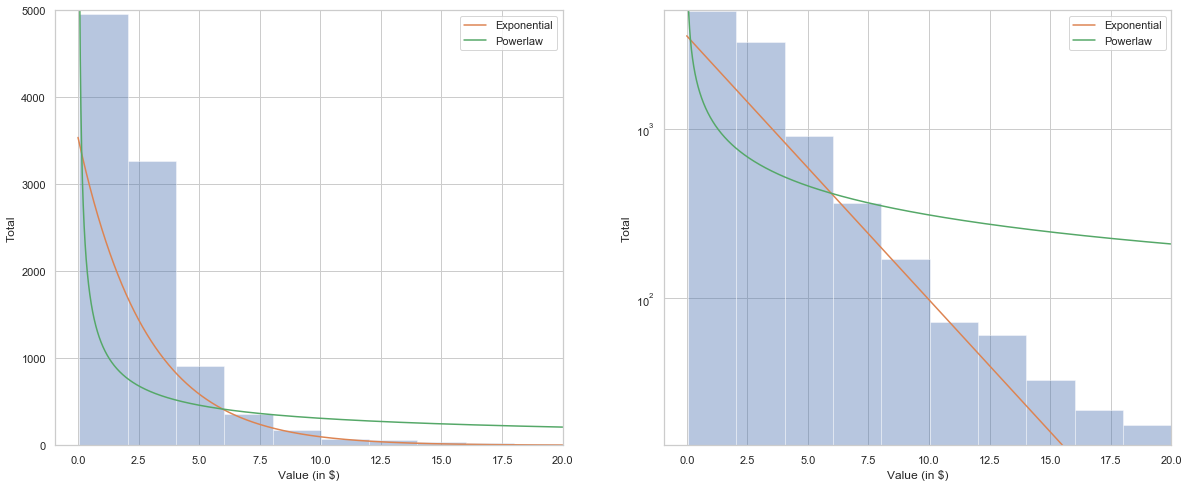

In [16]:
plot_distribution(df, r)

In [17]:
r = 20
df = df_transaction_data_cleaned['PRODUCT_PRICE'].sample(n=10000, random_state=1)
df = df[(df > 0) & (df < r)] # Remove the outliers

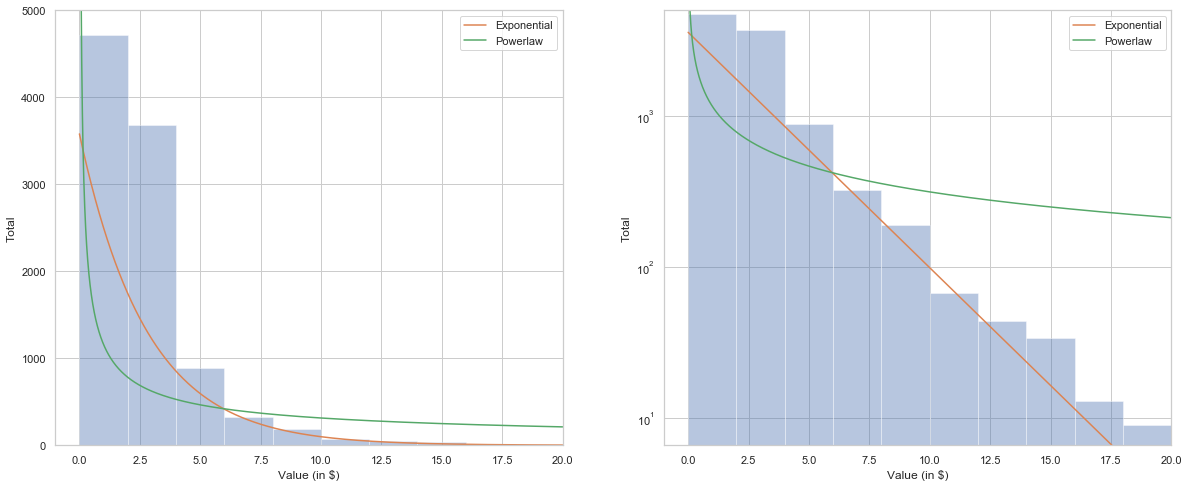

In [18]:
plot_distribution(df, r)

Looks like we have an exponential distribution for both columns.

### Joining Datasets

We join the two datasets to obtain the transactions for each household. 

In [19]:
df_households_transactions = df_transaction_data_cleaned.join(df_hh_demographic, on='household_key')

print('Total number of transactions for the selected households:',
      len(df_households_transactions))

Total number of transactions for the selected households: 1416672


## Part 3: Data Analysis

### Analysis of the Underlying Distributions

The following analysis can help us discover the shopping habits of the households, regardless of their annual income.

#### Household Income

We noted that one of the major factors in determining the household expenses is the household income category. This is represented by the `INCOME_DESC` column. It holds information about the total anual income for each household.

The main challenge in answering our question is the fact that this column is non numeric - each income value is represented as a category which represents an interval of income values. Looking on the bright side, there is meaningful ordering of the categories as they are intervals. 

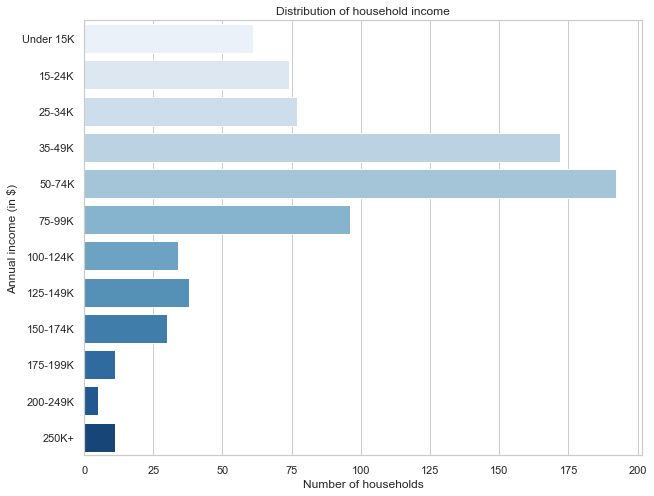

In [20]:
f, ax = plt.subplots(figsize=(10, 8))

income_desc = df_hh_demographic['INCOME_DESC'].value_counts()
sns.barplot(x=income_desc, y=income_desc.index, ax=ax, palette='Blues')
ax.set_title('Distribution of household income')
ax.set_xlabel('Number of households')
ax.set_ylabel('Annual income (in $)')

plt.show()

While there is nothing wrong with this plot on first sight, careful analysis reveils a large problem with it: The bins are not equidistant. Therefore, it is biased towards bins of larger range. For example, the *15-24K* bin only spans a *9K* income range, while the *200-249K* bin spans a *49K* range. For a fair plot, we need to divide all the bins by their range. That way, we get an approximate *income distribution density* of the number of households per *1K* income range.

In [21]:
def normalize(x):
    return x / np.sum(x)

bins = np.array([
    [15,0],
    [24,15],
    [34,25],
    [49,35],
    [74,50],
    [99,75],
    [124,100],
    [149,125],
    [174,150],
    [199,175],
    [249,200],
    [350,250]
])


diff = bins[:,0]-bins[:,1]

geo_means = np.sqrt(bins[:,0]*bins[:,1])

The `geo_means` variable is relevant, as it approximately represents the average value within every bin (assuming a log-normal distribution). The geometric mean between the lower and upper boud of a bin is more accurate than taking the average between the upper and lower bound. 

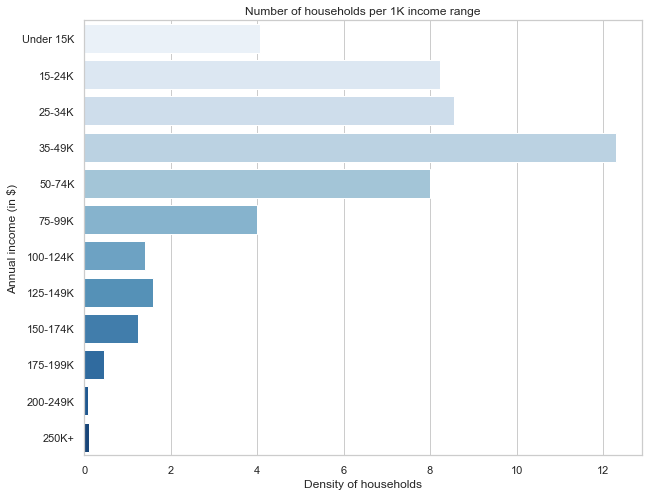

In [22]:
f, ax = plt.subplots(figsize=(10, 8))

income_desc = df_hh_demographic['INCOME_DESC'].value_counts().sort_index()
income_desc_density = (income_desc / diff).values

sns.barplot(x=income_desc_density, y=income_desc.index, ax=ax, palette='Blues')
ax.set_title('Number of households per 1K income range')
ax.set_xlabel('Density of households')
ax.set_ylabel('Annual income (in $)')

plt.show()

Here we can see that the distribution looks like a log-normal distribution, which was to be expected given the Central Limit Theorem for positive values (income can only take values larger than zero, so the distribution has to be log-normal, instead of normal). In the final phase of the project, we are going to fit a log-normal distribution upon this data to extract more information from it. 

#### Average Bill Amount

To measure the spending habits of the households, we compute the average amount of households' bills. Each household visit to a store is uniquely identified with a `BASKET_ID`. We do this in two steps:

1. We sum the derived `CUSTOMER_PAID` column across the transactions for each visit to get the total bill amount for the visit. <br>
2. We average across all visits of each household.

In [23]:
df_households_basket_payment = df_households_transactions \
    .groupby(['household_key', 'BASKET_ID'])['CUSTOMER_PAID'] \
    .sum()

df_households_basket_payment_average = df_households_basket_payment.groupby(['household_key']).mean()

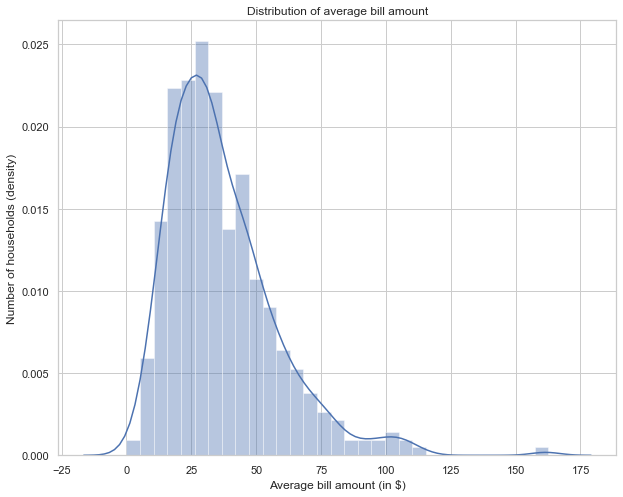

In [24]:
f, ax = plt.subplots(figsize=(10, 8))

sns.distplot(df_households_basket_payment_average)
ax.set_title('Distribution of average bill amount')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Number of households (density)')

plt.show()

Looking at the histogram of this statistic, we identify it as a right-skewed Gaussian distribution, with a few outliers.

On average, people spend around \\$30 at a local retailer, which is kind off expected. However, there are several outliers and this is further investigated bellow.

#### Average Price of the Most Expensive Product

Product prices are also reflective of the expenses that households have.

From this perspective, we can calculate a different statistic quantifying the spending habits of each household. This time we use the derived `PRODUCT_PRICE` to calculate the maximum product price in each basket and then average across for each household.

We calculate this statistic because first, the choice of most expensive product is a good indicator of the households spending habit during a trip. The average or lowest price of a product in the basket would not be relevant, as the first is very sensitive to outliers and the second will have low variance because common buying of cheap products. Finally, we aggregate the max product prices across each supermarket visit using the mean. 

In [25]:
df_households_basket_max_product_price = df_households_transactions \
    .groupby(['household_key', 'BASKET_ID'])['PRODUCT_PRICE'] \
    .max()

df_households_basket_max_product_price_average = df_households_basket_max_product_price.groupby('household_key').mean()

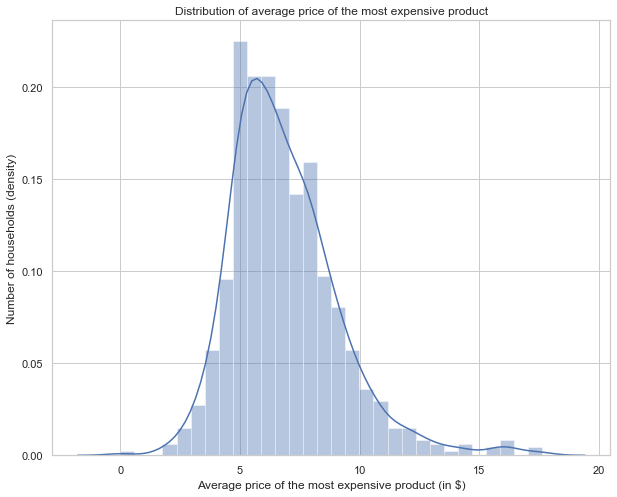

In [26]:
f, ax = plt.subplots(figsize=(10, 8))

sns.distplot(df_households_basket_max_product_price_average)
ax.set_title('Distribution of average price of the most expensive product')
ax.set_xlabel('Average price of the most expensive product (in $)')
ax.set_ylabel('Number of households (density)')

plt.show()

We observe from the histogram that this feature has a much more regular Gaussian distribution with a mean aroung \\$7. However, there are also outliers in this statistic. Some products can get as expensive as \\$100 of dolars which is depicted in another study bellow.

### Statistics Comparison

#### Correlation

We are interested in whether these two statistics are coorelated. Does the max product price determine the actual value on the bill?

Using a scatter plot, we would like to confirm (or deny) this.

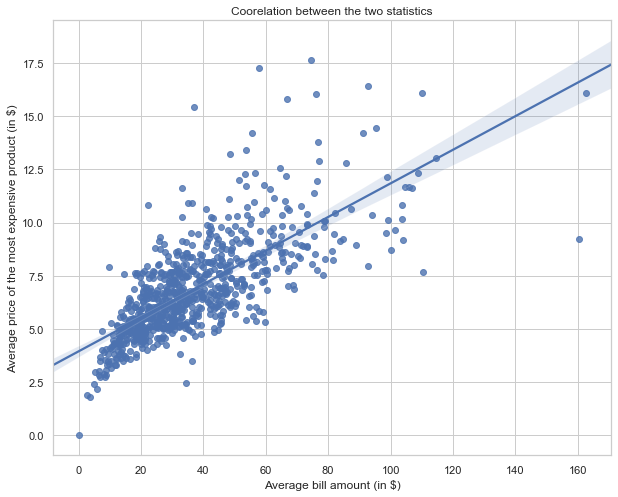

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.regplot(df_households_basket_payment_average, df_households_basket_max_product_price_average, ax=ax)
ax.set_title('Coorelation between the two statistics')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Average price of the most expensive product (in $)')

plt.show()

In [28]:
df_households_basket_payment_average.corr(df_households_basket_max_product_price_average, method='spearman')

0.7574264114900365

When using linear scales one can see an incrising monotonic associacion. One insight from the left plot is that, as the average bill amount rises, so does the number of product bought. In some cases, the price of the most expensive product will prevail, on others there will be more products with lower price. That is why the graph spreads more when the average bill amount rises.

### Analysis of the Joint Distribution 

Now that we have insight on how much money, on average, people spend on each visit to the store and how does the price of the most expensive product bought vary, we are interested to see does the household income play a crucial role in this. Our expectation is that it does, and that households with lower income spend less and buy cheeper products as opposed to households with higher income.

#### Household Income vs. Average Bill Amount

Using a boxplot we can view the distribution of the statistic across each household income category and perform a comparison very efficiently.

In [29]:
df = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_payment_average)

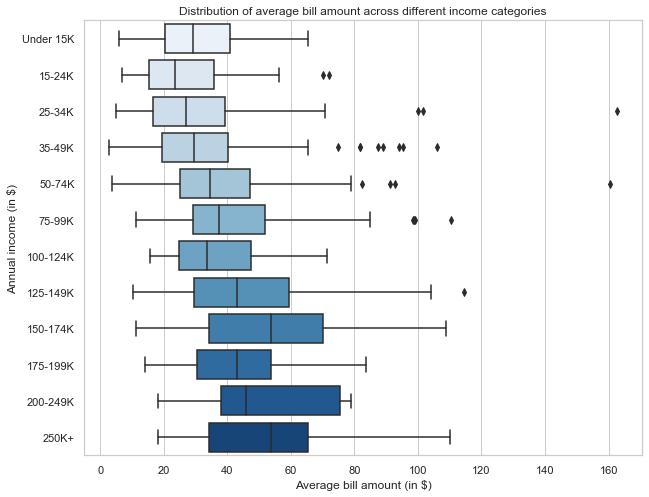

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='CUSTOMER_PAID', y='INCOME_DESC', data=df, palette='Blues')
ax.set_title('Distribution of average bill amount across different income categories')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Annual income (in $)')

plt.show()

To our surprise, extreme spending are mostly observed for medium and lower income households.

Using a 2D histogram i.e. heatmap we can compare the relationship between income and the statistic in more detail by viewing their joint distribution.

In [31]:
mapping = dict(zip(df['INCOME_DESC'], df['INCOME_DESC'].cat.codes))

df['INCOME_DESC'] = df['INCOME_DESC'] \
    .astype(str) \
    .map(mapping)

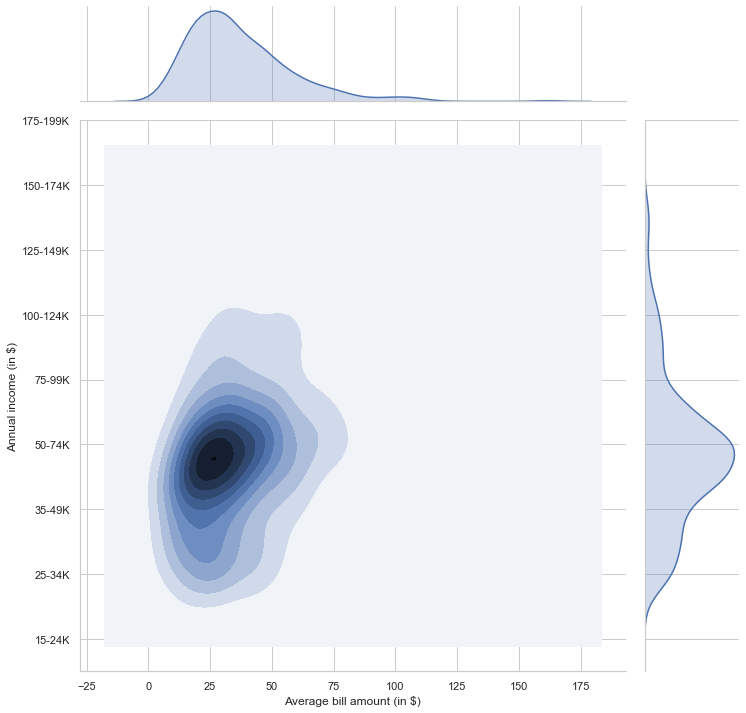

In [32]:
g = sns.jointplot(y='INCOME_DESC', x='CUSTOMER_PAID', data=df, kind='kde', height=10)
g.set_axis_labels(
    'Average bill amount (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);

We can observe that the majority of the households are concentrated at the medium income values of 35-74K and lower average expenses of about \\$20 - \\$40.

#### Household Income vs. Average Price of the Most Expensive Product

Similarly, to begin the comparison between household income and maximum product prices we first merge the two features of each household.

In [33]:
df = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_max_product_price_average)

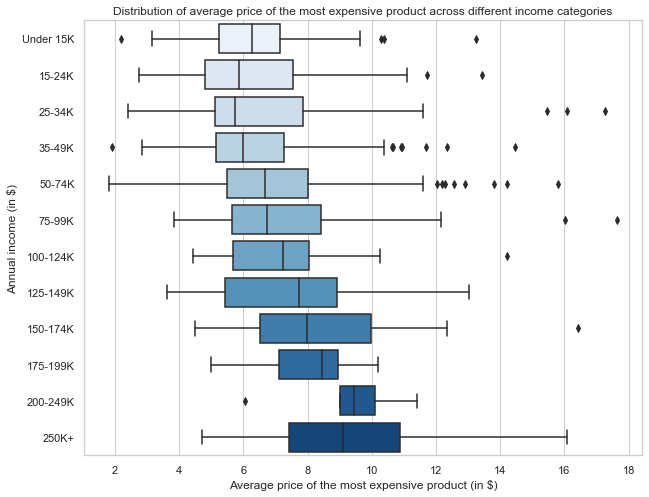

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='PRODUCT_PRICE', y='INCOME_DESC', data=df, palette='Blues')
ax.set_title('Distribution of average price of the most expensive product across different income categories')
ax.set_xlabel('Average price of the most expensive product (in $)')
ax.set_ylabel('Annual income (in $)')

plt.show()

The phenomena related to the extreme values is present here as well. Additionally, an interesting difference is the huge range of values for the richest households, perhaps capturing the fact that these households mostly purchase the most expensive products.

In [35]:
mapping = dict(zip(df['INCOME_DESC'], df['INCOME_DESC'].cat.codes))

df['INCOME_DESC'] = df['INCOME_DESC'].astype(str).map(mapping)

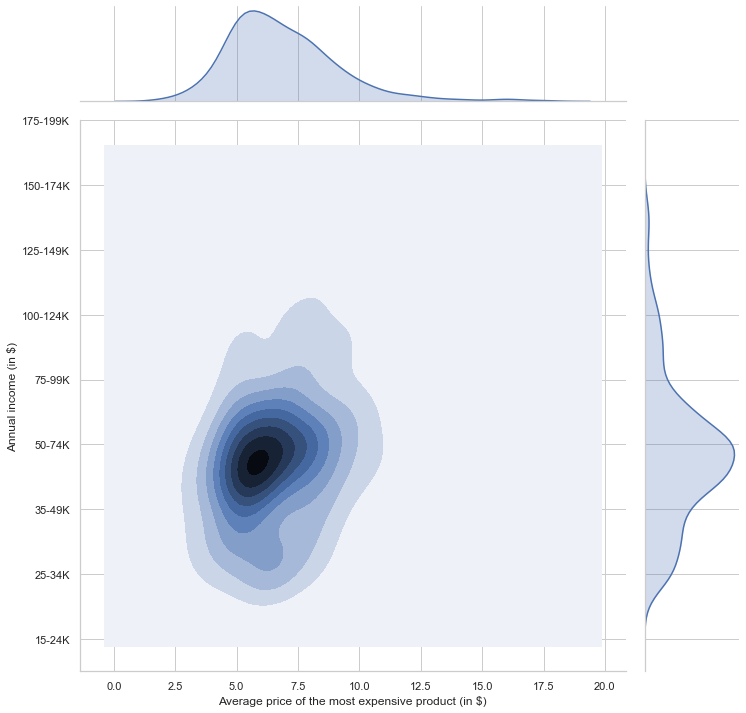

In [36]:
g = sns.jointplot(y='INCOME_DESC', x='PRODUCT_PRICE', data=df, kind='kde', height=10)
g.set_axis_labels(
    'Average price of the most expensive product (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);

Analyzing the joint distribution, we observe that it is very similar in form to the one for the previous statistic, further proving their equivalence.

## Trends

#### Coupon usage

We noticed that campaigns play a major role in how people spend their money. In deriving the true amount of money that households spend on every visit to the store, we took into account the coupon value. But what is the total amount used and does it vary with the income category?

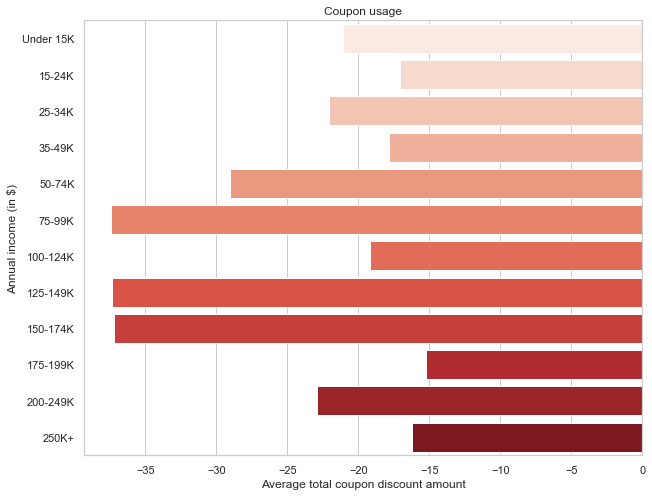

In [37]:
df = df_households_transactions.groupby(['INCOME_DESC'], observed=True)['COUPON_DISC'] \
    .sum() \
    .div(df_hh_demographic['INCOME_DESC'].value_counts()) \
    .reset_index()

df.columns = ['INCOME_DESC', 'COUPON_DISC']

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y='INCOME_DESC', x='COUPON_DISC', data=df, palette='Reds', ax=ax)
ax.set_title('Coupon usage')
ax.set_ylabel('Annual income (in $)')
ax.set_xlabel('Average total coupon discount amount')
plt.show()

Coupon value is negative, since it gives a discount to the price. On this bar plot, we see a somewhat unexpected trend. People with medium to upper medium income use more coupons as opposed to the people with lower income. Interesting sight is that people with high income are also heavy users of coupons.

#### Daily Expenses

Interesting information can be found by looking into the day of the week when purchases have been made. While we don't know the exact date (and thereby day of the week) from when the data was recorded, it is enough to group the transactions by the *day number* module *7*, in order to plot the transactions throughout an average week. 

In [38]:
df = df_households_transactions.copy()

df['DAY'] = df['DAY'].apply(lambda d: d % 7)

df = df.groupby(['DAY'])['CUSTOMER_PAID'] \
    .sum() \
    .reset_index()

df = df['CUSTOMER_PAID'] / len(df_hh_demographic)

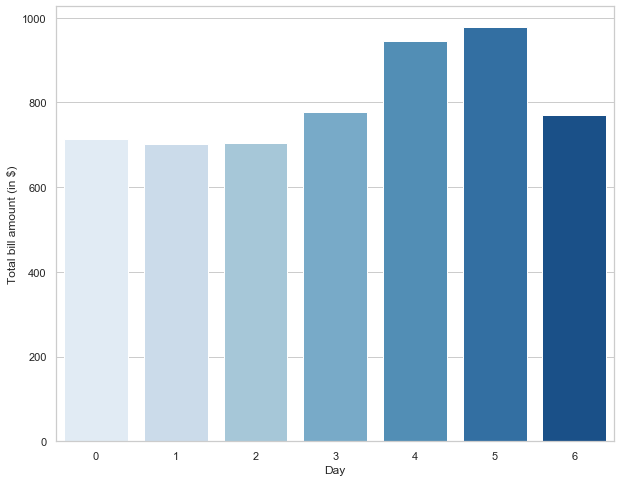

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x=df.index, y=df.values, ax=ax, palette='Blues')
    
ax.set_xlabel('Day')
ax.set_ylabel('Total bill amount (in $)')
    
plt.show()

While we cannot be certain about which day this weeks starts with, it is to be assumed that that the two days with a larger amount of transactions are either Friday and Saturday or Saturday and Sunday. If the data is from the US, it is likely that most purchases have been made on Sunday, as people tend to have more time for shopping, and the stores are usually open on Sunday. We contacted the company which provides this dataset for more information about such details, and are currently waiting for a response. 

#### Mapping Between Expenses and Product Categories

Here we are interested to find out how household expenditure depends on the goods and/or services and how does it vary with household income. For this analysis, we will load the `product.csv` dataset. It contains information about a particular product associated with a transaction.

In [40]:
df_product = pd.read_csv(DATA_DIR + PRODUCT, index_col='PRODUCT_ID')

print('Number of products:', len(df_product))

df_product.head()

Number of products: 92353


,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
PRODUCT_ID,,,,,,
25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [41]:
print('Columns with missing values in products dataset:',
      np.any(df_product.isna().sum()))

Columns with missing values in products dataset: False


Although, there are no missing values, the `CURR_SIZE_OF_PRODUCT` column has empty string values. As this is not crutial for our analysis, we are not going to further address this issue. 

We join the household transactions dataset with the products dataset using the `PRODUCT_ID` column.

In [42]:
df_transactions_products = \
    df_households_transactions[['PRODUCT_ID', 'QUANTITY', 'CUSTOMER_PAID', 'INCOME_DESC']] \
    .join(df_product[['COMMODITY_DESC', 'SUB_COMMODITY_DESC']], on='PRODUCT_ID')

df_transactions_products.head()

,PRODUCT_ID,QUANTITY,CUSTOMER_PAID,INCOME_DESC,COMMODITY_DESC,SUB_COMMODITY_DESC
11,842930,1,2.19,100-124K,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS
12,897044,1,2.99,100-124K,CRACKERS/MISC BKD FD,SNACK CRACKERS
13,920955,1,3.09,100-124K,BEEF,GRND/PATTY - ROUND
14,937406,1,2.50,100-124K,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW
15,981760,1,0.60,100-124K,EGGS,EGGS - X-LARGE


The following dataset is just an aggregate over `INCOME_DESC` and `COMMODITY_DESC`. It is usefull for our analysis that follow.

In [43]:
df = df_transactions_products \
    .groupby(['INCOME_DESC', 'SUB_COMMODITY_DESC'], observed=True)['CUSTOMER_PAID'] \
    .sum() \
    .dropna() \
    .to_frame()

df.head()

CUSTOMER_PAID
INCOME_DESC SUB_COMMODITY_DESC                  
Under 15K   *BOYS/GIRLS MISC TOYS           9.99
            *SCRAPBOOK                      3.49
            *SPORT NOVELTIES                2.99
            *SPRING/SUMMER MISC             2.00
            ABRASIVES                      36.96

#### Most Purchased Product

We are interested to see on which product does the households spend most of their money on. This is also dependent on the income category.

In [44]:
df.unstack().idxmax(axis=1)

INCOME_DESC
Under 15K    (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
15-24K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
25-34K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
35-49K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
50-74K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
75-99K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
100-124K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
125-149K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
150-174K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
175-199K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
200-249K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
250K+        (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
dtype: object

It looks like they spend most of their anual income on gasoline, which is expected taking into account the demographics data of the households. But lets see the distribution.

In [45]:
stats = df.unstack()['CUSTOMER_PAID']['GASOLINE-REG UNLEADED'] \
    .div(df_hh_demographic['INCOME_DESC'].value_counts().values) \
    .values

stats

array([ 143.42822917,  123.37703488,  293.16083333,  892.79519481,
       1392.28081081,  842.9404918 ,  670.58394737,  924.67705882,
        842.97866667,  738.80818182,   50.73272727,  845.314     ])

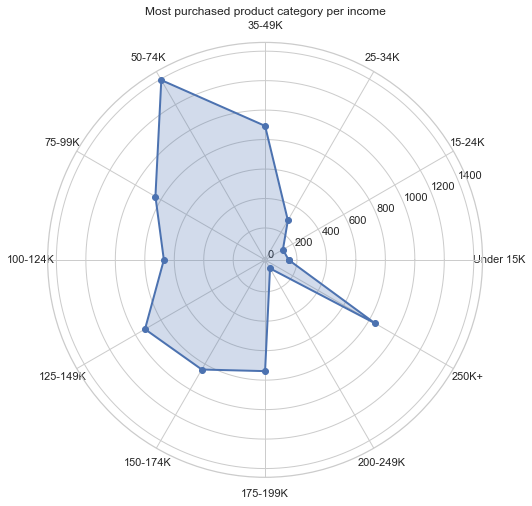

In [46]:
angles = np.linspace(0, 2 * np.pi, len(income_desc_categories), endpoint=False)
stats = np.concatenate((stats, [stats[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, income_desc_categories)
ax.set_title('Most purchased product category per income')
ax.grid(True)

plt.show()

The distribution is highly concentrated around the middle to upper middle income categories. The reason is that households with lower income can't afford owning a vehicle, however the reason for the upper income is somewhat unclear. It could be that they use other means of transportation required by their job.

Setting gasoline aside, we are also interest in how the expenses are distributed in the other product categories.

In [47]:
dff = df[df.index.get_level_values('SUB_COMMODITY_DESC') != 'GASOLINE-REG UNLEADED']

dff.head()

CUSTOMER_PAID
INCOME_DESC SUB_COMMODITY_DESC                  
Under 15K   *BOYS/GIRLS MISC TOYS           9.99
            *SCRAPBOOK                      3.49
            *SPORT NOVELTIES                2.99
            *SPRING/SUMMER MISC             2.00
            ABRASIVES                      36.96

For this, we will use a sankey plot because it is an excelent way to visualise flow of information between two subsets. From it, we will have a clear idea about how the expenses from income groups map to product categories.

We will use top 200 products ordered by `QUANTITY` plot the flow diagram between the income and the product category. We can easily visualise how the quantity of the purchased products is distributed and later search for patterns in the expenditure.

In [48]:
dff = dff \
    .reset_index() \
    .groupby(['INCOME_DESC'], observed=True)['SUB_COMMODITY_DESC', 'CUSTOMER_PAID'] \
    .apply(lambda df: df.sort_values(by='CUSTOMER_PAID', ascending=False).head(15)) \
    .reset_index(level=0)

# dff = dff \
#     .reset_index() \
#     .sort_values(by='CUSTOMER_PAID', ascending=False) \
#     .head(200)

dff

,INCOME_DESC,SUB_COMMODITY_DESC,CUSTOMER_PAID
1466,Under 15K,SOFT DRINKS 12/18&15PK CAN CAR,8161.77
562,Under 15K,FLUID MILK WHITE ONLY,5937.73
327,Under 15K,CIGARETTES,4630.39
319,Under 15K,CHOICE BEEF,4218.34
142,Under 15K,BEERALEMALT LIQUORS,3793.83
...,...,...,...
18109,250K+,ALL FAMILY CEREAL,975.26
18598,250K+,FRZN BAGGED VEGETABLES - PLAIN,960.68
18737,250K+,ISOTONIC DRINKS MULTI-SERVE,926.58
19385,250K+,TOILET TISSUE,865.56


In [49]:
data = []

palette = sns.color_palette('cubehelix', len(dff) + dff['INCOME_DESC'].nunique())
colours = palette.as_hex()

level1 = dff[['INCOME_DESC', 'CUSTOMER_PAID']] \
    .groupby('INCOME_DESC', observed=True) \
    .agg('sum')

c_count = 0

for i, r in level1.reset_index().iterrows():
    data.append({
        'source': 'Expenditure',
        'target': r['INCOME_DESC'],
        'value': r['CUSTOMER_PAID'],
        'color': colours[c_count]
    })
    
    item_dff = dff[dff['INCOME_DESC'] == r['INCOME_DESC']] \
        [['INCOME_DESC', 'SUB_COMMODITY_DESC', 'CUSTOMER_PAID']] \
        .groupby(['INCOME_DESC', 'SUB_COMMODITY_DESC'], observed=True) \
        .agg('sum') \
        .reset_index()
    
    for item_i, item_r in item_dff.iterrows():
        
        c_count += 1

        data.append({
            'source': item_r['INCOME_DESC'],
            'target': item_r['SUB_COMMODITY_DESC'],
            'value': item_r['CUSTOMER_PAID'],
            'color': colours[c_count]
        })

In [50]:
# w = SankeyWidget(layout=Layout(width='1600', height='3000'),
#                  links=data,
#                  margins=dict(top=0, bottom=0, left=100, right=150))

# w

In [51]:
# w.save_png('sankey.png')

<img src="sankey.png" />

In order to analyse this sankey diagram further, we call on a principle from microeconomics, called **Engel curves**.

#### Engel curves

One particular way of determining how household expenditure, on a particular good or service, varies with household income is visualising Engel curves. Engel curves on the x-axis have the income category and on the y-axis the quantity of the measured product. We can infer some type of goods using these curves.

In [52]:
df = df_transactions_products \
    .groupby(['INCOME_DESC', 'COMMODITY_DESC'], observed=True)['QUANTITY'] \
    .sum() \
    .dropna() \
    .reset_index(level=1)

For a start, here are the 10 most purchased items:

In [53]:
df.groupby('COMMODITY_DESC')['COMMODITY_DESC','QUANTITY'].sum().sort_values('QUANTITY',ascending=False).head(10)

,QUANTITY
COMMODITY_DESC,
COUPON/MISC ITEMS,162074939
SOFT DRINKS,83004
FLUID MILK PRODUCTS,63878
BAKED BREAD/BUNS/ROLLS,52732
CHEESE,52510
SOUP,46598
YOGURT,45343
VEGETABLES - SHELF STABLE,44701
BAG SNACKS,43166


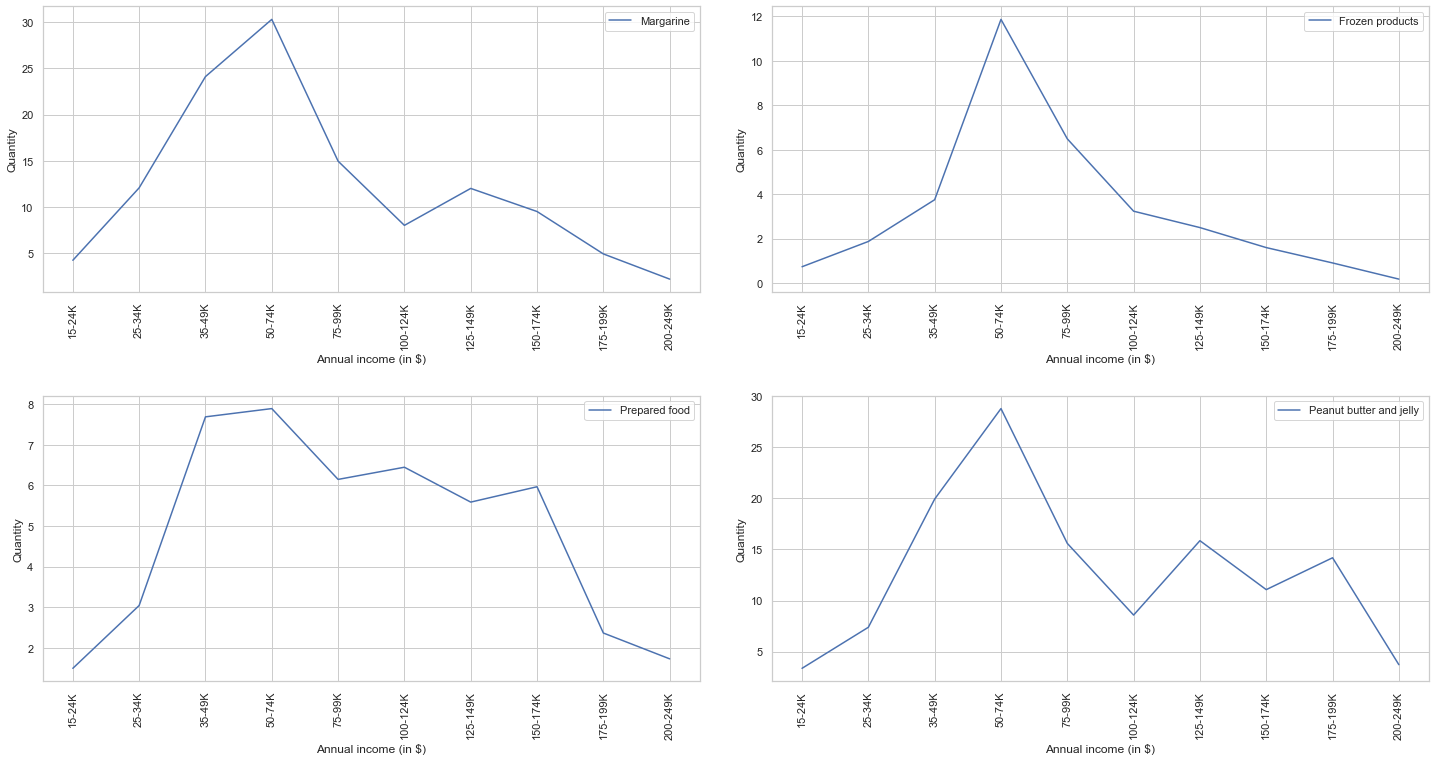

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

fig.tight_layout(h_pad=8, w_pad=4)

x = np.arange(len(income_desc_categories))

def plot_scatter(commodity_desc, label, ax):    
    y = df.query(f'COMMODITY_DESC == "{commodity_desc}"')['QUANTITY'] \
        .div(df_hh_demographic['INCOME_DESC'].value_counts().values)
    
    # Remove the first and last income category because
    # they contain all the outliers
    new_x = x[1:-1]
    new_y = y[1:-1]
    
    sns.lineplot(x=new_x, y=new_y, palette='Blues', ax=ax, label=label)
    ax.set_xticks(new_x)
    ax.set_xticklabels(income_desc_categories[1:-1], rotation='vertical')
    ax.set_xlabel('Annual income (in $)')
    ax.set_ylabel('Quantity')

plot_scatter('MARGARINES', 'Margarine', axes[0, 0])
plot_scatter('FROZEN', 'Frozen products', axes[0, 1])
plot_scatter('PREPARED FOOD', 'Prepared food', axes[1, 0])
plot_scatter('PNT BTR/JELLY/JAMS', 'Peanut butter and jelly', axes[1, 1])

plt.legend()
plt.show()

Here we showcase an example of inferior goods. Margaring is an inferior good since its demand drops when people's incomes rise. This occurs when a good has more costly substitutes (butter) that see an increase in demand as incomes and the economy improve. There are other examples in our dataset (ex. frozen food, prepared food, peanut butter and jelly).

When looking at the above plots, one might be surprised that for all four products, households with low incomes, and households with extremely high income tend to purchase fewer of them. For households with low income, this is no surprise. But what about high-income households? It is likely that individuals of high incomes often dine out, as this saves time. That way, they don't have to purchase large quanitites of any products in supermarkets. 

### Demographic Analysis of Household Groups

In order to understand how family values influence the balance between household's expenses and income, we will analyze the demographic properties across 4 groups of households.

In [55]:
AVG_INCOME = '50-74K'
AVG_EXPENSES = 32.2431

In [56]:
df = df_hh_demographic.join(df_households_basket_payment_average.to_frame().rename(columns={'CUSTOMER_PAID': 'EXPENSES'}))

df_low_income_low_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_low_income_high_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]
df_high_income_low_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_high_income_high_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]

In [57]:
print('Percent of households with low income and low expenses:', round(len(df_low_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with low income and high expenses:', round(len(df_low_income_high_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and low expenses:', round(len(df_high_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and high expenses:', round(len(df_high_income_high_expenses) / len(df_hh_demographic), 4))

Percent of households with low income and low expenses: 0.4082
Percent of households with low income and high expenses: 0.3109
Percent of households with high income and low expenses: 0.0924
Percent of households with high income and high expenses: 0.1885


These groups were generated using the average income and average expenses. We split the households into: below (or above) average income and below (or above) average expenses.

In [58]:
def plot_demographic(column_name, demographic_categories, demographic_feature_name):
    df = pd.concat([
        df_low_income_low_expenses[column_name].value_counts().rename('Low/ Low') / len(df_low_income_low_expenses),
        df_low_income_high_expenses[column_name].value_counts().rename('Low/ High') / len(df_low_income_high_expenses),
        df_high_income_low_expenses[column_name].value_counts().rename('High/ Low') / len(df_high_income_low_expenses),
        df_high_income_high_expenses[column_name].value_counts().rename('High/ High') / len(df_high_income_high_expenses)
    ], axis=1, sort=False)
    df.index = demographic_categories
    df = df.unstack().reset_index()
    df.columns = ['Income vs. Expenses', demographic_feature_name, 'Percentage of households']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.barplot(x=demographic_feature_name, y='Percentage of households', hue='Income vs. Expenses', data=df)
    ax.set_title(f'Demographic analysis of household groups - {demographic_feature_name}')
    
    plt.show()

#### Age

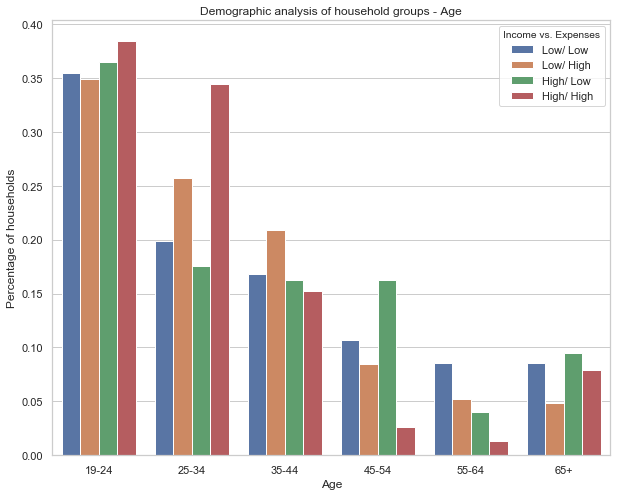

In [59]:
column_name = 'AGE_DESC'
demographic_categories = ['19-24', '25-34', '35-44', '45-54', '55-64', '65+']
demographic_feature_name = 'Age'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

From the age distribution of the household groups, we can make a few interesting observations. Among the households with the youngest members there is not a lot of variety in the income-expenses balance. Among the households with members of younger working ages high expenses seem to dominate. As we move to the households with older members lower expenses are more prevalent.

#### Martial Status

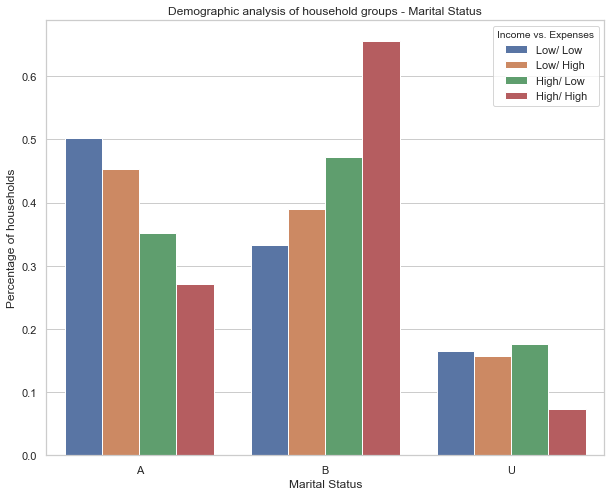

In [60]:
column_name = 'MARITAL_STATUS_CODE'
demographic_categories = ['A', 'B', 'U']
demographic_feature_name = 'Marital Status'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

For clarification, according to the dataset documentation the marital status codes `A`, `B`, and `U` stand for `Married`, `Single` and `Unknown` respectively. Interestingly, this plot efficiently captures classical differences between married and single life, as we observe that **households with married members have more often lower income and must balance with lower expenses**, while it is completely opposite for **single member households, as they more frequently have higher income and are able to indulge in higher expenses**.  

#### Homeowner Type

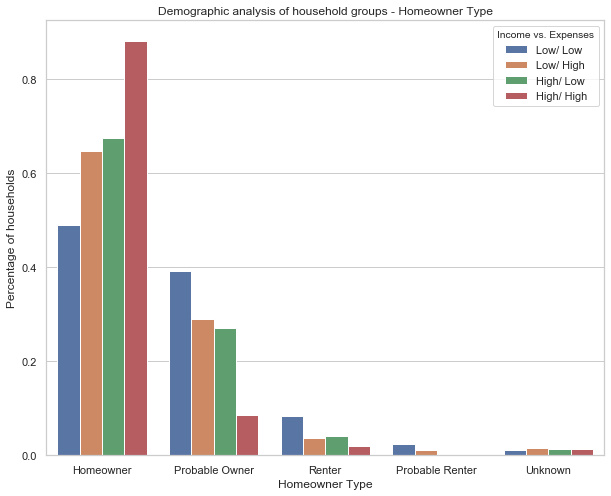

In [61]:
column_name = 'HOMEOWNER_DESC'
demographic_categories = ['Homeowner', 'Probable Owner', 'Renter', 'Probable Renter', 'Unknown']
demographic_feature_name = 'Homeowner Type'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

Analyzing the distribution of the type of homeownership we again obtain expected results, as it is understandable that it is most probable for households who are able to afford their own place of residence to have higher income and expenses, while renters usually have better sense of utilizing their limited income. 

#### Household Composition

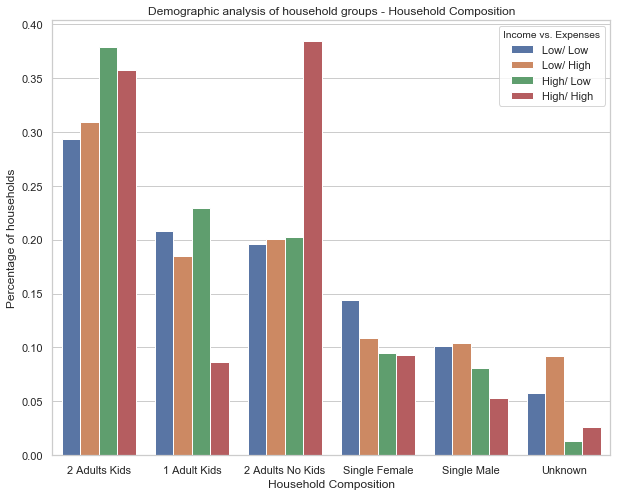

In [62]:
column_name = 'HH_COMP_DESC'
demographic_categories = ['2 Adults Kids', '1 Adult Kids', '2 Adults No Kids', 'Single Female', 'Single Male', 'Unknown']
demographic_feature_name = 'Household Composition'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

Among the different household compositions recorded in the data, we do not observe a lot of variety and this feature is not a good discriminator. However, we do observe two interesting discrepancies which can also be expected: couples with no children have the highest chance to be in the group with the highest income and expenses, while single parents tend to have a "harder time".

#### Household Size

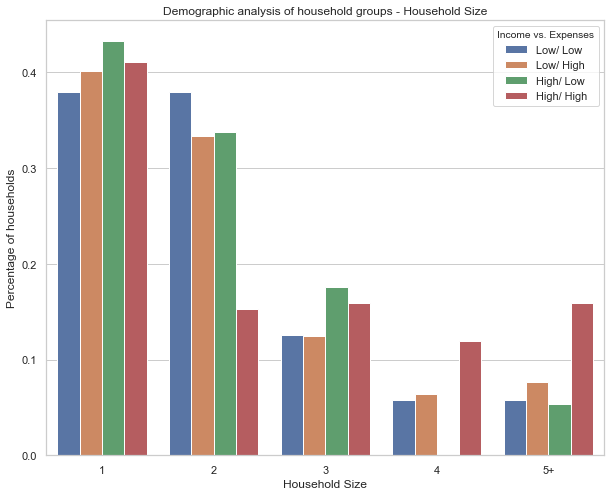

In [63]:
column_name = 'HOUSEHOLD_SIZE_DESC'
demographic_categories = ['1', '2', '3', '4', '5+']
demographic_feature_name = 'Household Size'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

The household size feature also displays very little significance for group distinction across different values. However, we can observe a trend that as the household size increases the probability of having lower income and expenses decreases, as only households with higher income can afford to have more children, but with that their expenses also increase.

#### Number of Children

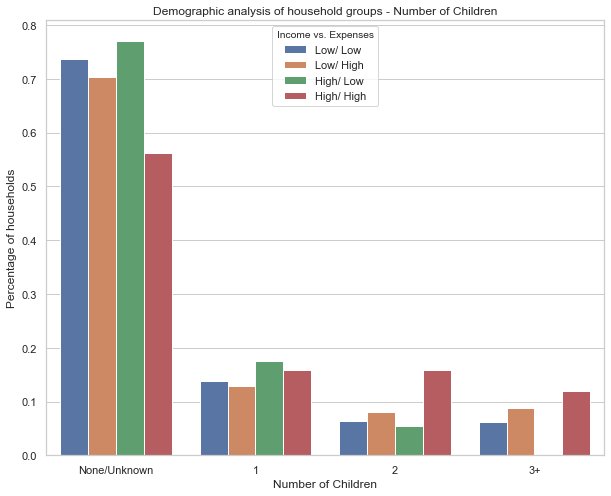

In [64]:
column_name = 'KID_CATEGORY_DESC'
demographic_categories = ['None/Unknown', '1', '2', '3+']
demographic_feature_name = 'Number of Children'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

The demographic records for the number of children can be inferred from previous features such as household size and household composition and as such in the plot we observe a similar trend as in the previous analysis of household size.

## Part 4: Applied ML

We are interested in whether there is existence of clusters in `hh_demographic` dataset. Since all the columns are categorical, we first transform the dataset using one-hot-encoding per column. Then, we apply PCA to project the dataset into 2 dimensional space, and finally apply KMeans clustering.

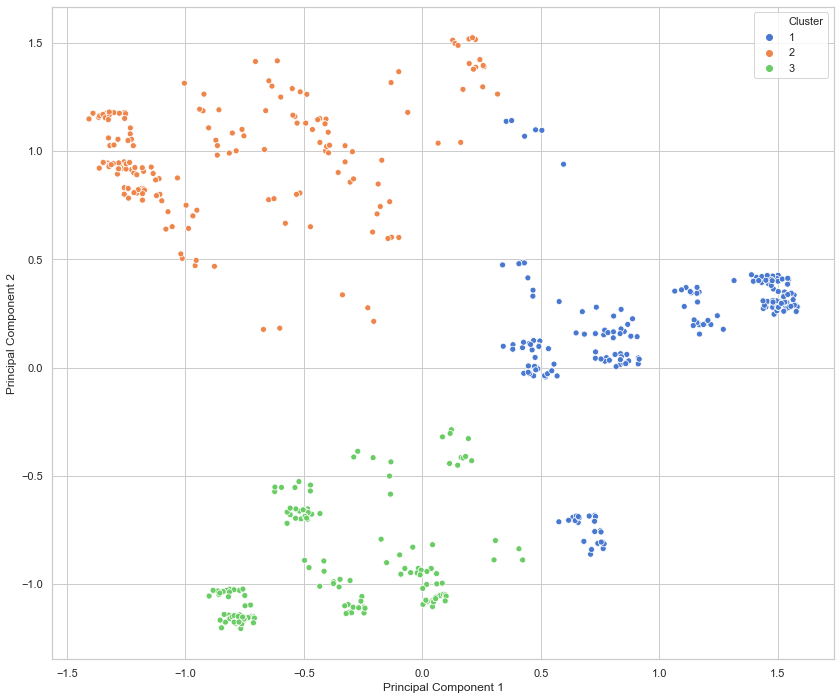

In [65]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

c = (df_hh_demographic['MARITAL_STATUS_CODE'] != 'U') & \
    (df_hh_demographic['HOMEOWNER_DESC'] != 'Unknown') & \
    (df_hh_demographic['KID_CATEGORY_DESC'] != 'None/Unknown')

k = 3

X = pd.get_dummies(df_hh_demographic)

pca = PCA(n_components=2).fit(X)

X_proj = pca.transform(X)

kmeans = KMeans(n_clusters=k).fit(X_proj)

df = pd.DataFrame(np.concatenate((X_proj, kmeans.labels_.reshape(-1, 1)+1), axis=1), columns=['Principal Component 1', 'Principal Component 2', 'Cluster'])
df['Cluster'] = df['Cluster'].astype(int)

f, ax = plt.subplots(figsize=(14, 12))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2',  data=df, hue='Cluster', palette=sns.color_palette('muted', n_colors=k))
plt.show()

Although, PCA is hard to interpret, however, in the graph above we can see that there are 2 or 3 distinguishable clusters. This might suggest of cluster existence in higher dimensions and we will use this information for further insights in the final version of the project. It is also evident that there are roughly 16 smaller cluster in the above plot. This is due to the discretization of the data. Even after performing PCA, the discrete values become part of the two main components, and therefore also discretize the data into groups. Therefore, we can safely ignore those 16 smaller groups, as they are no "deeper" meaning. 

## Part 5: Recap and Future Steps

**Outliers**:
There are plots with significant outliers. We will look at those in order to find out what they are, and if the influence the dataset in any statistically significant way. Maybe also compare how the average bill amount changes with the demographic data 



**Problem with average bill amount**
as opposed to using the average bill amount, use either number of items or average item price because:

*Average(bill + coupons) ~ average(# of items) * average_item_price*


We want to plot vs. either the first, or the second, but not their product! Why?
The average number of items purchased is heavily related to haw many family members there are (large family = more stuff to buy)
The average item price is more related to how wealthily a person is (more money = more fancy organic products). 


**Problem with looking at the average price of the most expensive item**:
The more items you buy, the more likely you are to buy something expensive. Therefore, max price is a bad indicator. Better use average price per product or sth like that. (we already have a variable calculating the average product price btw (`df_transaction_data_cleaned['PRODUCT_PRICE'] = (sales_value - (retail_disc + coupon_match_disc)) / quantity`)
